In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
def get_largest_tokenIn_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))
    
    return df

def get_largest_tokenIn_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenIn_symbol').alias('token'),
        pl.col('amountInUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_largest_tokenOut_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenOut_symbol')
        .agg(pl.col("amountOutUSD").sum())
        .sort(by="amountOutUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenOut_symbol').alias('token'),
        pl.col('amountOutUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_all_token_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    df_in = get_largest_tokenIn_vol(df_filepaths, blockchain)
    df_out = get_largest_tokenOut_vol(df_filepaths, blockchain)

    # concat
    df = pl.concat([df_in, df_out])

    # groupby token and sum volume again
    df = df.groupby('token').agg(pl.col('volume').sum()).sort(by='volume', descending=True)

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))
    
    return df

In [4]:
eth_data = get_all_token_vol(df_filepaths, 'ethereum')
arb_data = get_all_token_vol(df_filepaths, 'arbitrum')
opt_data = get_all_token_vol(df_filepaths, 'optimism')
poly_data = get_all_token_vol(df_filepaths, 'polygon')
bsc_data = get_all_token_vol(df_filepaths, 'bsc')

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [5]:
# concat data
token_vol_df = pl.concat([eth_data, arb_data, opt_data, poly_data, bsc_data])

# sort
token_vol_df = token_vol_df.sort(by="volume", descending=True)

### Plotting

In [6]:
token_vol_df_pandas = token_vol_df.head(20).to_pandas()

In [7]:
# pivot blockchain column to column headers. Make token the index
pivot_df = token_vol_df_pandas.pivot(index='token', columns='blockchain', values='volume')

In [8]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [9]:
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [10]:
pivot_df

blockchain,arbitrum,bsc,ethereum,optimism,polygon,sum
token,,,,,,
BUSD,NaN,1.770758e+09,NaN,NaN,NaN,1.770758e+09
PEPE,NaN,NaN,1.977353e+09,NaN,NaN,1.977353e+09
WMATIC,NaN,NaN,NaN,NaN,2.708363e+09,2.708363e+09
WBNB,NaN,3.180452e+09,NaN,NaN,NaN,3.180452e+09
DAI,NaN,NaN,4.678329e+09,NaN,NaN,4.678329e+09
WBTC,1.125022e+09,NaN,3.647666e+09,NaN,NaN,4.772687e+09
ARB,8.922696e+09,NaN,NaN,NaN,NaN,8.922696e+09
USDT,5.152190e+09,3.549366e+09,2.332087e+10,NaN,1.245489e+09,3.326792e+10
USDC,1.605044e+10,NaN,5.560196e+10,1.831784e+09,3.641295e+09,7.712548e+10


In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'


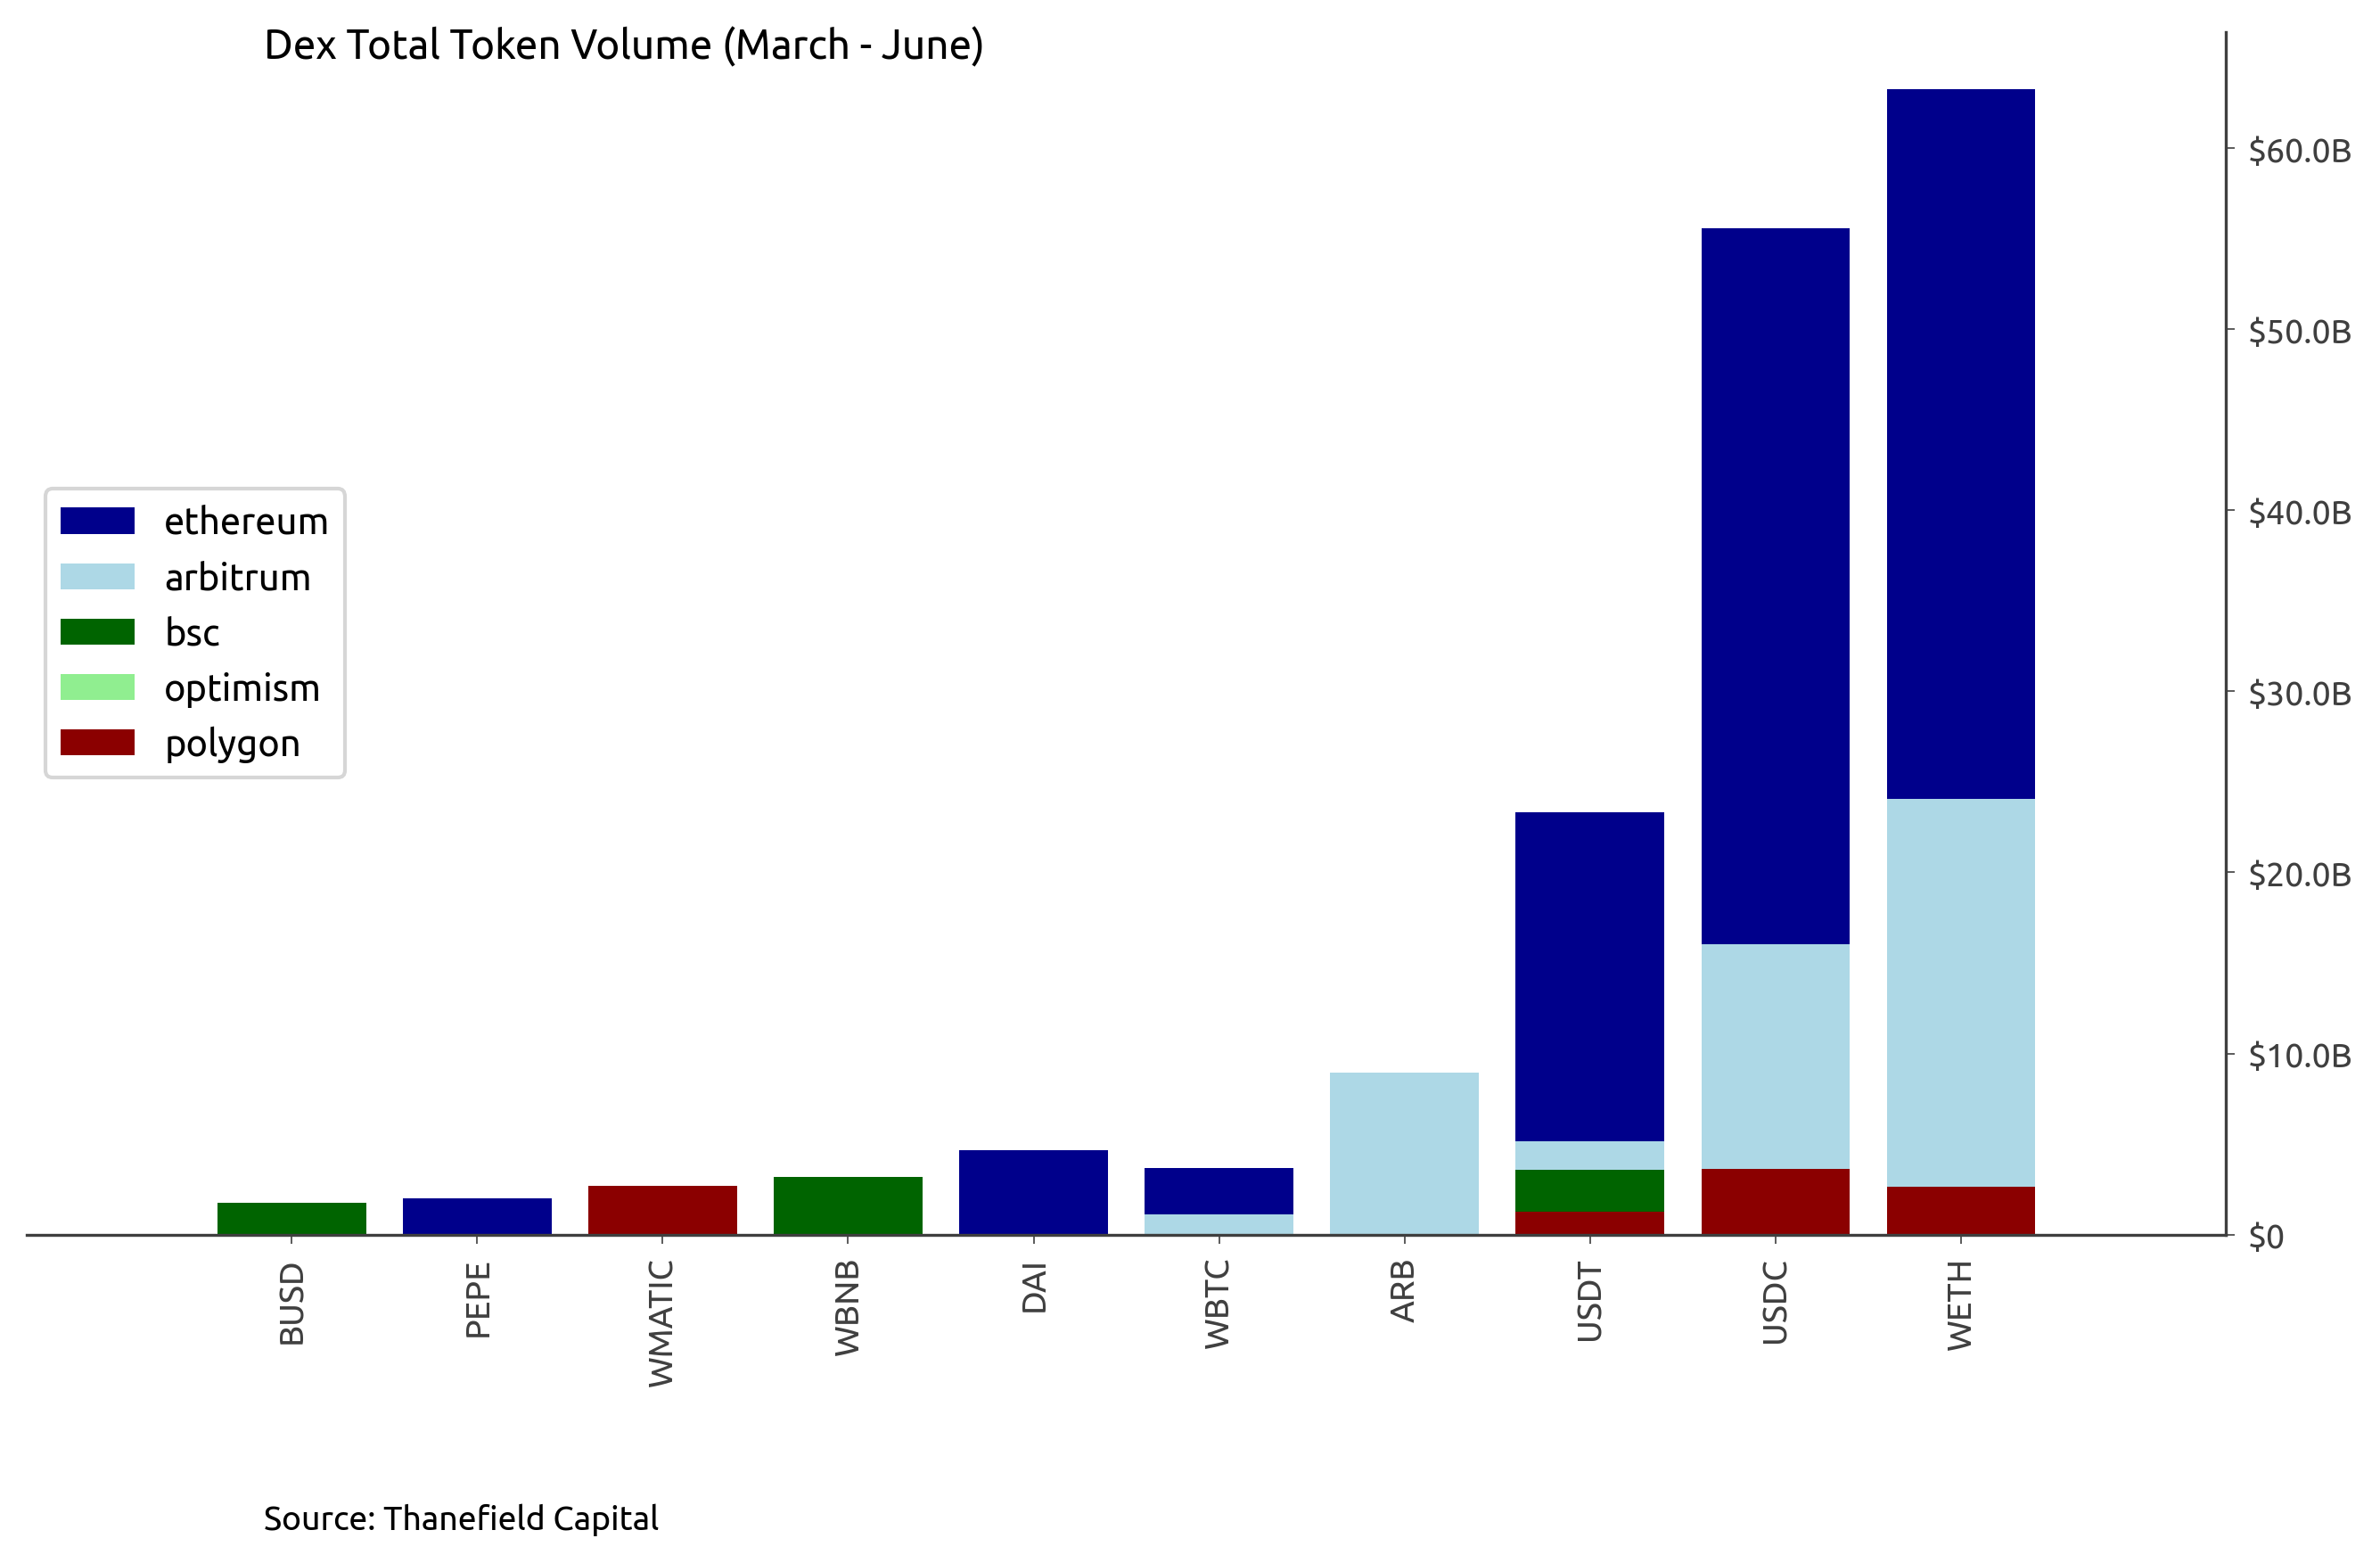

In [12]:
# note each token has over 1b volume
fig, ax = tc.chart('Dex Token Volume (March - June)', dates=False)

ax.bar(pivot_df.index, pivot_df['ethereum'], color='darkblue', label='ethereum')
ax.bar(pivot_df.index, pivot_df['arbitrum'], color='lightblue', label='arbitrum')
ax.bar(pivot_df.index, pivot_df['bsc'], color='darkgreen', label='bsc')
ax.bar(pivot_df.index, pivot_df['optimism'], color='lightgreen', label='optimism')
ax.bar(pivot_df.index, pivot_df['polygon'], color='darkred', label='polygon')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
tc.save('charts/dex_total_token_vol.png')